# StatArb Pairs: Optimized Mean-Reversion Trading System

## Project Overview

This Jupyter notebook implements a sophisticated **pairs trading strategy** using **statistical arbitrage** techniques and **Bayesian optimization**. The system is designed to identify and exploit mean-reversion opportunities in financial markets.

### Key Components:

1. **Data Collection & Preprocessing**
   - Download historical stock data using `yfinance`
   - Pair selection using cointegration tests

2. **Pairs Trading Strategy Development**
   - Implementation of `PairTradingStrategy` class
   - Utilization of key parameters: lookback, entry_threshold, stoploss_factor, half_life

3. **Backtesting Engine**
   - Custom `BacktestEngine` class using Backtrader
   - Comprehensive performance metrics and visualization

4. **Bayesian Optimization**
   - Parameter optimization using `skopt`
   - Objective function based on Sharpe Ratio

5. **Results Analysis**
   - Equity curve plotting
   - Trade table generation
   - Performance metrics calculation

### Project Structure:

1. **Data Download & Storage**
   - Function to download and save stock data for multiple tickers

2. **Pair Selection**
   - Cointegration tests, correlation analysis, and ADF test for pair selection

3. **Strategy Implementation**
   - `PairTradingStrategy` class with entry/exit logic and risk management

4. **Backtesting Engine**
   - `BacktestEngine` class for running and analyzing backtests

5. **Parameter Optimization**
   - Bayesian optimization to find optimal strategy parameters

6. **Main Execution**
   - Pair selection, parameter optimization, and final backtest execution

This project demonstrates the application of statistical methods and machine learning optimization in developing a robust pairs trading system.

# 1. Donwloand & Store the data

In [14]:
import yfinance as yf
import os
from datetime import datetime

# # List of 49 forex tickers
list_tickers = [
    "AUDCAD", "AUDCHF", "AUDEUR", "AUDGBP", "AUDJPY", "AUDNZD", "AUDUSD", 
    "CADAUD", "CADCHF", "CADEUR", "CADGBP", "CADJPY", "CADNZD", "CHFAUD", 
    "CHFCAD", "CHFEUR", "CHFGBP", "CHFJPY", 'CHFNZD', 'EURAUD', 'EURCAD',
    'EURCHF', 'EURGBP', 'EURJPY', 'EURNZD', 'EURUSD', 'GBPAUD', 'GBPCAD',
    'GBPCHF', 'GBPEUR', 'GBPJPY', 'GBPNZD', 'GBPUSD', 'JPYAUD', 'JPYCAD',
    'JPYCHF', 'JPYEUR', 'JPYGBP', 'JPYNZD', 'NZDAUD', 'NZDCAD', 'NZDCHF',
    'NZDEUR', 'NZDGBP', 'NZDJPY', 'NZDUSD', 'USDCAD', 'USDCHF', 'USDJPY']
# Add "=X" to each symbol
list_tickers = [symbol + '=X' for symbol in list_tickers]

# # List of 50 stock tickers
#list_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'BRK-A', 'V', 'JPM', 'JNJ', 'WMT', 'UNH', 'MA', 'PG', 'NVDA', 'HD', 'DIS', 'PYPL', 'BAC', 'CMCSA', 'ADBE', 'XOM', 'INTC', 'VZ', 'NFLX', 'T', 'CRM', 'ABT', 'CSCO', 'PEP', 'PFE', 'KO', 'MRK', 'NKE', 'CVX', 'WFC', 'ORCL', 'MCD', 'COST', 'ABBV', 'MDT', 'TMO', 'ACN', 'HON', 'UNP', 'IBM', 'UPS', 'LIN', 'LLY', 'AMT']

# # list of 10 stock tickers
# list_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'BRK-A', 'V', 'JPM', 'JNJ']

# Set start and end times
start_time = '2020-01-01'
end_time = '2023-01-01'

# Create a folder to save data if it doesn't exist
folder_name = 'data'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Function to download and save data for a stock
def download_and_save_stock_data(ticker):
    try:
        # Download data
        data = yf.download(ticker, start=start_time, end=end_time)
        
        # Create file name
        file_name = os.path.join(folder_name, f"{ticker}.csv")
        
        # Save data to CSV file
        data.to_csv(file_name)
        print(f"Downloaded and saved data for {ticker}")
    except Exception as e:
        print(f"Error downloading data for {ticker}: {str(e)}")

# Download and save data for all stocks
for ticker in list_tickers:
    download_and_save_stock_data(ticker)

print("Completed downloading data for all stocks.")

[*********************100%***********************]  1 of 1 completed
Downloaded and saved data for AUDCAD=X
[*********************100%***********************]  1 of 1 completed
Downloaded and saved data for AUDCHF=X
[*********************100%***********************]  1 of 1 completed
Downloaded and saved data for AUDEUR=X
[*********************100%***********************]  1 of 1 completed
Downloaded and saved data for AUDGBP=X
[*********************100%***********************]  1 of 1 completed
Downloaded and saved data for AUDJPY=X
[*********************100%***********************]  1 of 1 completed
Downloaded and saved data for AUDNZD=X
[*********************100%***********************]  1 of 1 completed
Downloaded and saved data for AUDUSD=X
[*********************100%***********************]  1 of 1 completed
Downloaded and saved data for CADAUD=X
[*********************100%***********************]  1 of 1 completed
Downloaded and saved data for CADCHF=X
[*********************100%**

# 2. Find best 2 Pairs for Pair Trading Strategy ( Cointegration Test, Correlation, ADF Test )

In [15]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import coint, adfuller
import os
from itertools import combinations

def load_stock_data(ticker, data_folder='stock_data'):
    """Load stock data from CSV file."""
    return pd.read_csv(os.path.join(data_folder, f'{ticker}.csv'), index_col='Date', parse_dates=True)

def calculate_log_spread_and_zscore(stock1, stock2):
    """Calculate log spread and its z-score."""
    log_spread = np.log(stock1['Close']) - np.log(stock2['Close'])
    z_score = (log_spread - log_spread.mean()) / log_spread.std()
    return log_spread, z_score

def analyze_pair(stock1, stock2):
    """Analyze a pair of stocks for cointegration, correlation, and stationarity."""
    log_spread, z_score = calculate_log_spread_and_zscore(stock1, stock2)
    
    # Check Cointegration
    score, pvalue, _ = coint(stock1['Close'], stock2['Close'])
    
    # Calculate Correlation
    correlation = stock1['Close'].corr(stock2['Close'])
    
    # Augmented Dickey-Fuller Test on log spread
    adf_result = adfuller(log_spread)
    
    return {
        'cointegration_pvalue': pvalue,
        'correlation': correlation,
        'adf_pvalue': adf_result[1],
        'log_spread': log_spread,
        'z_score': z_score
    }

def analyze_all_pairs(tickers, data_folder='stock_data'):
    """Analyze all possible pairs from the given list of tickers."""
    results = []
    
    for ticker1, ticker2 in combinations(tickers, 2):
        try:
            stock1 = load_stock_data(ticker1, data_folder)
            stock2 = load_stock_data(ticker2, data_folder)
            
            # Ensure both stocks have the same date range
            common_dates = stock1.index.intersection(stock2.index)
            stock1 = stock1.loc[common_dates]
            stock2 = stock2.loc[common_dates]
            
            result = analyze_pair(stock1, stock2)
            
            results.append({
                'pair': f'{ticker1}-{ticker2}',
                'cointegration_pvalue': result['cointegration_pvalue'],
                'correlation': result['correlation'],
                'adf_pvalue': result['adf_pvalue'],
                'mean_zscore': result['z_score'].mean(),
                'std_zscore': result['z_score'].std()
            })
        except Exception as e:
            print(f"Error analyzing pair {ticker1}-{ticker2}: {str(e)}")
    
    return pd.DataFrame(results)

def filter_suitable_pairs(df_results, cointegration_threshold=0.05, adf_threshold=0.05):
    """Filter pairs suitable for pair trading based on cointegration and stationarity."""
    return df_results[
        (df_results['cointegration_pvalue'] < cointegration_threshold) &
        (df_results['adf_pvalue'] < adf_threshold)
    ].sort_values('correlation', ascending=False)

def find_best_pair(tickers, data_folder='data', cointegration_threshold=0.05, adf_threshold=0.05):
    """Find the best pair for pair trading from the given list of tickers."""
    all_pairs = analyze_all_pairs(tickers, data_folder)
    suitable_pairs = filter_suitable_pairs(all_pairs, cointegration_threshold, adf_threshold)
    
    if suitable_pairs.empty:
        return None, pd.DataFrame()  # Return None and an empty DataFrame instead of a string
    
    best_pair = suitable_pairs.iloc[0]
    stock1, stock2 = best_pair['pair'].split('-')
    
    # Load data for the best pair to calculate additional metrics
    stock1_data = load_stock_data(stock1, data_folder)
    stock2_data = load_stock_data(stock2, data_folder)
    common_dates = stock1_data.index.intersection(stock2_data.index)
    stock1_data = stock1_data.loc[common_dates]
    stock2_data = stock2_data.loc[common_dates]
    
    log_spread, z_score = calculate_log_spread_and_zscore(stock1_data, stock2_data)
    
    return {
        'stock1': stock1,
        'stock2': stock2,
        'correlation': best_pair['correlation'],
        'cointegration_pvalue': best_pair['cointegration_pvalue'],
        'adf_pvalue': best_pair['adf_pvalue'],
        'mean_zscore': best_pair['mean_zscore'],
        'std_zscore': best_pair['std_zscore'],
        'log_spread': log_spread,
        'z_score': z_score
    }, suitable_pairs

# 3. Pair Trading Strategy

## 3.1. Calculate Kappa & Half-Life

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

def calculate_spread(stock1, stock2):
    return np.log(stock1['Close']) - np.log(stock2['Close'])

def calculate_half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    
    spread_lag2 = sm.add_constant(spread_lag)
    
    model = sm.OLS(spread_ret, spread_lag2)
    res = model.fit()
    
    halflife = -np.log(2) / res.params[1]
    
    return halflife

def calculate_kappa_half_life(spread):
    # Calculate Kappa
    spread_lag = spread.shift(1)
    delta_spread = spread - spread_lag
    reg = np.polyfit(spread_lag.dropna(), delta_spread.dropna(), deg=1)
    kappa = -reg[0]
    
    # Calculate Half-Life
    half_life = calculate_half_life(spread)
    
    return kappa, half_life

def calculate_kappa_and_half_life(stock1_data, stock2_data, plot=True):
    # Ensure both stocks have the same date range
    common_dates = stock1_data.index.intersection(stock2_data.index)
    stock1_data = stock1_data.loc[common_dates]
    stock2_data = stock2_data.loc[common_dates]
    
    # Calculate spread
    spread = calculate_spread(stock1_data, stock2_data)
    
    # Calculate Kappa and Half-Life
    kappa, half_life = calculate_kappa_half_life(spread)
    
    if plot:
        # Plot the spread
        plt.figure(figsize=(12, 6))
        plt.plot(spread)
        plt.title(f'Price Spread')
        plt.xlabel('Date')
        plt.ylabel('Spread')
        plt.show()
    
    return kappa, half_life

## 3.2 - Pair Trading Strategy ( Z-Score, Entry, Exit, Profit )

### use with Kappa & Half-Life

In [17]:
import backtrader as bt
import numpy as np
from collections import deque

class PairTradingStrategy(bt.Strategy):
    params = (
        ('lookback', 20),
        ('entry_threshold', 1.5),  # Entry threshold in terms of standard deviations
        ('stoploss_factor', 2.0),  # Stop-loss threshold in terms of standard deviations
        ('holding_time_factor', 1.5),  # Factor to determine max holding time based on half-life
        ('half_life', 14),  # Estimated half-life of mean reversion in days
        ('stock1', None),
        ('stock2', None),
    )

    def __init__(self):
        # Get the data for the two stocks
        self.stock1 = self.getdatabyname(self.params.stock1)
        self.stock2 = self.getdatabyname(self.params.stock2)

        # Initialize spread and mean/std
        self.spread = []
        self.mean = None
        self.std = None
        self.entry_price = None # Entry price for the current position
        self.entry_date = None # Entry date for the current position

        # Calculate max holding time
        self.max_holding_time = int(self.params.holding_time_factor * self.params.half_life)

        # Custom metrics tracking
        self.trades = []
        self.equity_curve = [self.broker.getvalue()]
        self.returns = deque(maxlen=252)  # For annual Sharpe ratio
        self.max_drawdown = 0
        self.peak = self.broker.getvalue()

    def next(self):
        # Calculate the spread
        spread = np.log(self.stock1.close[0]) - np.log(self.stock2.close[0])
        self.spread.append(spread)

        # Wait until we have enough data
        if len(self.spread) <= self.params.lookback:
            return

        # Calculate mean and standard deviation
        self.mean = np.mean(self.spread[-self.params.lookback:])
        self.std = np.std(self.spread[-self.params.lookback:])

        # Calculate trading thresholds
        buy_threshold = self.mean - self.params.entry_threshold * self.std
        sell_threshold = self.mean + self.params.entry_threshold * self.std

        # Trading logic
        # No existing position
        if not self.position: 
            if spread < buy_threshold:
                self.buy(data=self.stock1)
                self.sell(data=self.stock2)
                self.entry_price = spread
                self.entry_date = len(self)
                self.log_trade('ENTRY LONG')
            elif spread > sell_threshold:
                self.sell(data=self.stock1)
                self.buy(data=self.stock2)
                self.entry_price = spread
                self.entry_date = len(self)
                self.log_trade('ENTRY SHORT')
        # Existing position
        else: 
            # Check for exit conditions
            days_since_entry = len(self) - self.entry_date

            # Trong phần exit logic
            if (self.position.size > 0 and spread >= self.mean) or \
            (self.position.size < 0 and spread <= self.mean):
                self.close(data=self.stock1)
                self.close(data=self.stock2)
                self.log_trade('EXIT', days_since_entry, reason="Spread Reversion")
            elif days_since_entry >= self.max_holding_time:
                self.close(data=self.stock1)
                self.close(data=self.stock2)
                self.log_trade('EXIT', days_since_entry, reason="Max Holding Time")
                return

            # Check for stop-loss
            stop_loss_threshold = self.params.stoploss_factor * self.std
            if abs(spread - self.entry_price) > stop_loss_threshold:
                self.close(data=self.stock1)
                self.close(data=self.stock2)
                self.log_trade('STOP-LOSS', days_since_entry, reason="Stop-Loss Hit")

        # Update metrics
        current_value = self.broker.getvalue()
        self.equity_curve.append(current_value)
        
        # Calculate return
        if len(self.equity_curve) > 1:
            daily_return = (current_value - self.equity_curve[-2]) / self.equity_curve[-2]
            self.returns.append(daily_return)
        
        # Update max drawdown
        if current_value > self.peak:
            self.peak = current_value
        dd = (self.peak - current_value) / self.peak
        if dd > self.max_drawdown:
            self.max_drawdown = dd

    def log_trade(self, action, days_held=None, reason=None):
        if action.startswith('ENTRY'):
            self.entry_date = len(self)
            self.entry_price1 = self.stock1.close[0]
            self.entry_price2 = self.stock2.close[0]
        elif action in ['EXIT', 'STOP-LOSS']:
            exit_price1 = self.stock1.close[0]
            exit_price2 = self.stock2.close[0]
            pnl = self.broker.getvalue() - self.equity_curve[-1]
            pnl_pct = (pnl / self.equity_curve[-1]) * 100
            self.trades.append({
                'entry_date': self.data.datetime.date(-days_held) if days_held is not None else None,
                'exit_date': self.data.datetime.date(0),
                'days_held': days_held,
                'pnl': pnl,
                'pnl_pct': pnl_pct,
                'entry_price1': self.entry_price1,
                'entry_price2': self.entry_price2,
                'exit_price1': exit_price1,
                'exit_price2': exit_price2,
                'exit_type': action,
                'exit_reason': reason
            })

    def stop(self):
        # Calculate final metrics
        self.total_trades = len(self.trades)
        self.winning_trades = sum(1 for trade in self.trades if trade['pnl'] > 0)
        self.losing_trades = sum(1 for trade in self.trades if trade['pnl'] <= 0)
        self.win_rate = self.winning_trades / self.total_trades if self.total_trades > 0 else 0

        self.total_return = (self.equity_curve[-1] - self.equity_curve[0]) / self.equity_curve[0]
        self.mean_return = np.mean(self.returns) if self.returns else 0
        self.std_return = np.std(self.returns) if self.returns else 0
        self.sharpe_ratio = np.sqrt(252) * self.mean_return / self.std_return if self.std_return != 0 else 0

        # Store all metrics in a dictionary for easy access
        self.metrics = {
            'Initial Capital': self.equity_curve[0],
            'Final Portfolio Value': self.equity_curve[-1],
            'Total Return (%)': self.total_return * 100,
            'Sharpe Ratio': self.sharpe_ratio,
            'Max Drawdown (%)': self.max_drawdown * 100,
            'Total Trades': self.total_trades,
            'Winning Trades': self.winning_trades,
            'Losing Trades': self.losing_trades,
            'Win Rate (%)': self.win_rate * 100,
            'Mean Daily Return (%)': self.mean_return * 100,
            'Std Dev of Daily Return (%)': self.std_return * 100
        }

## 3.3 - Define Backtest Engine 

In [18]:
import backtrader as bt
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

class BacktestEngine:
    def __init__(self, strategy_class, df1, df2, initial_capital=100000, commission=0.001):
        self.cerebro = bt.Cerebro()
        self.strategy_class = strategy_class
        self.df1 = df1
        self.df2 = df2
        self.initial_capital = initial_capital
        self.commission = commission
        self.results = None

    def add_data(self):
        data1 = bt.feeds.PandasData(dataname=self.df1, name="stock1")
        data2 = bt.feeds.PandasData(dataname=self.df2, name="stock2")
        self.cerebro.adddata(data1)
        self.cerebro.adddata(data2)

    def set_strategy(self, **kwargs):
        self.cerebro.addstrategy(self.strategy_class, **kwargs)

    def set_broker(self, initial_capital=None, commission=None):
        if initial_capital is None:
            initial_capital = self.initial_capital
        if commission is None:
            commission = self.commission

    def run(self):
        self.add_data()
        self.set_broker()
        self.results = self.cerebro.run()

    def get_metrics(self):
        if not self.results:
            return {"Error": "No backtest results available. Please run the backtest first."}

        strat = self.results[0]
        
        if not hasattr(strat, 'metrics'):
            return {"Error": "No metrics found in the strategy. Make sure to implement custom metrics in your strategy."}
        
        return strat.metrics

    def print_metrics(self):
        metrics = self.get_metrics()
        if isinstance(metrics, dict) and "Error" in metrics:
            print(metrics["Error"])
            return

        table_data = [["Metric", "Value"]]
        for key, value in metrics.items():
            if isinstance(value, float):
                table_data.append([key, f"{value:.2f}"])
            else:
                table_data.append([key, value])

        print("\nBacktest Results:")
        print(tabulate(table_data, headers="firstrow", tablefmt="grid"))

    def print_trade_table(self, num_trades=None):
        if not self.results:
            print("No results available. Make sure to run the backtest first.")
            return
        
        strat = self.results[0]
        if not hasattr(strat, 'trades'):
            print("No trade information found in the strategy. Make sure to log trades in your strategy.")
            return

        trades = strat.trades
        if num_trades is not None:
            trades = trades[:num_trades]
        
        trade_data = []
        for trade in trades:
            trade_data.append([
                trade.get('entry_date', 'N/A'),
                trade.get('exit_date', 'N/A'),
                trade.get('days_held', 'N/A'),
                f"{trade.get('pnl', 'N/A'):.2f}",
                f"{trade.get('pnl_pct', 'N/A'):.2f}%",
                f"{trade.get('entry_price1', 'N/A'):.2f}",
                f"{trade.get('entry_price2', 'N/A'):.2f}",
                f"{trade.get('exit_price1', 'N/A'):.2f}",
                f"{trade.get('exit_price2', 'N/A'):.2f}",
                trade.get('exit_type', 'N/A'), 
                trade.get('exit_reason', 'N/A')
            ])
        
        headers = ["Entry Date", "Exit Date", "Days Held", "PnL", "PnL %", 
                   "Entry Price 1", "Entry Price 2", "Exit Price 1", "Exit Price 2", "Exit Type", "Exit Reason"]
        
        print("\nTrade History:")
        print(tabulate(trade_data, headers=headers, tablefmt="grid"))

    def plot_equity_curve(self):
        if not self.results:
            print("No results available. Make sure to run the backtest first.")
            return
        
        strat = self.results[0]
        if not hasattr(strat, 'equity_curve'):
            print("No equity curve data found in the strategy.")
            return
        
        # Convert equity curve to pandas Series
        equity_curve = pd.Series(strat.equity_curve, index=self.df1.index[:len(strat.equity_curve)])
        
        # Calculate drawdown
        drawdown = (equity_curve.cummax() - equity_curve) / equity_curve.cummax()
        
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [3, 1]})
        fig.suptitle('Equity Curve and Drawdown', fontsize=16)
        
        # Plot equity curve
        ax1.plot(equity_curve.index, equity_curve.values, label='Equity Curve', color='blue')
        ax1.set_title('Equity Curve')
        ax1.set_ylabel('Portfolio Value')
        ax1.legend()
        ax1.grid(True)
        
        # Plot drawdown
        ax2.fill_between(drawdown.index, drawdown.values, 0, alpha=0.3, color='red', label='Drawdown')
        ax2.set_title('Drawdown')
        ax2.set_ylabel('Drawdown')
        ax2.set_xlabel('Date')
        ax2.legend()
        ax2.grid(True)
        
        # Format x-axis
        plt.gcf().autofmt_xdate()
        
        # Add strategy performance metrics as text
        metrics = self.get_metrics()
        metrics_text = (f"Total Return: {metrics['Total Return (%)']:.2f}%\n"
                        f"Sharpe Ratio: {metrics['Sharpe Ratio']:.2f}\n"
                        f"Max Drawdown: {metrics['Max Drawdown (%)']:.2f}%\n"
                        f"Win Rate: {metrics['Win Rate (%)']:.2f}%")
        fig.text(0.02, 0.02, metrics_text, fontsize=10, va='bottom')
        
        # Adjust layout
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Show plot
        plt.show()

    def plot_results(self):
        if not self.results:
            print("No results available. Make sure to run the backtest first.")
            return

        plt.figure(figsize=(12, 6))
        plt.subplot(2, 1, 1)
        self.cerebro.plot(style='candlestick')
        plt.title('Backtest Results')
        
        plt.subplot(2, 1, 2)
        strat = self.results[0]
        if hasattr(strat, 'equity_curve'):
            plt.plot(strat.equity_curve)
            plt.title('Portfolio Value Over Time')
        else:
            print("No equity curve data found in the strategy.")
        
        plt.tight_layout()
        plt.show()

## 3.4 - Backtest Pair Trading Strategy


Backtest Results:
+-----------------------------+----------+
| Metric                      |    Value |
+=============================+==========+
| Initial Capital             | 10000    |
+-----------------------------+----------+
| Final Portfolio Value       | 10000    |
+-----------------------------+----------+
| Total Return (%)            |     0    |
+-----------------------------+----------+
| Sharpe Ratio                |    -0.43 |
+-----------------------------+----------+
| Max Drawdown (%)            |     0    |
+-----------------------------+----------+
| Total Trades                |    85    |
+-----------------------------+----------+
| Winning Trades              |    57    |
+-----------------------------+----------+
| Losing Trades               |    28    |
+-----------------------------+----------+
| Win Rate (%)                |    67.06 |
+-----------------------------+----------+
| Mean Daily Return (%)       |    -0    |
+-----------------------------+----

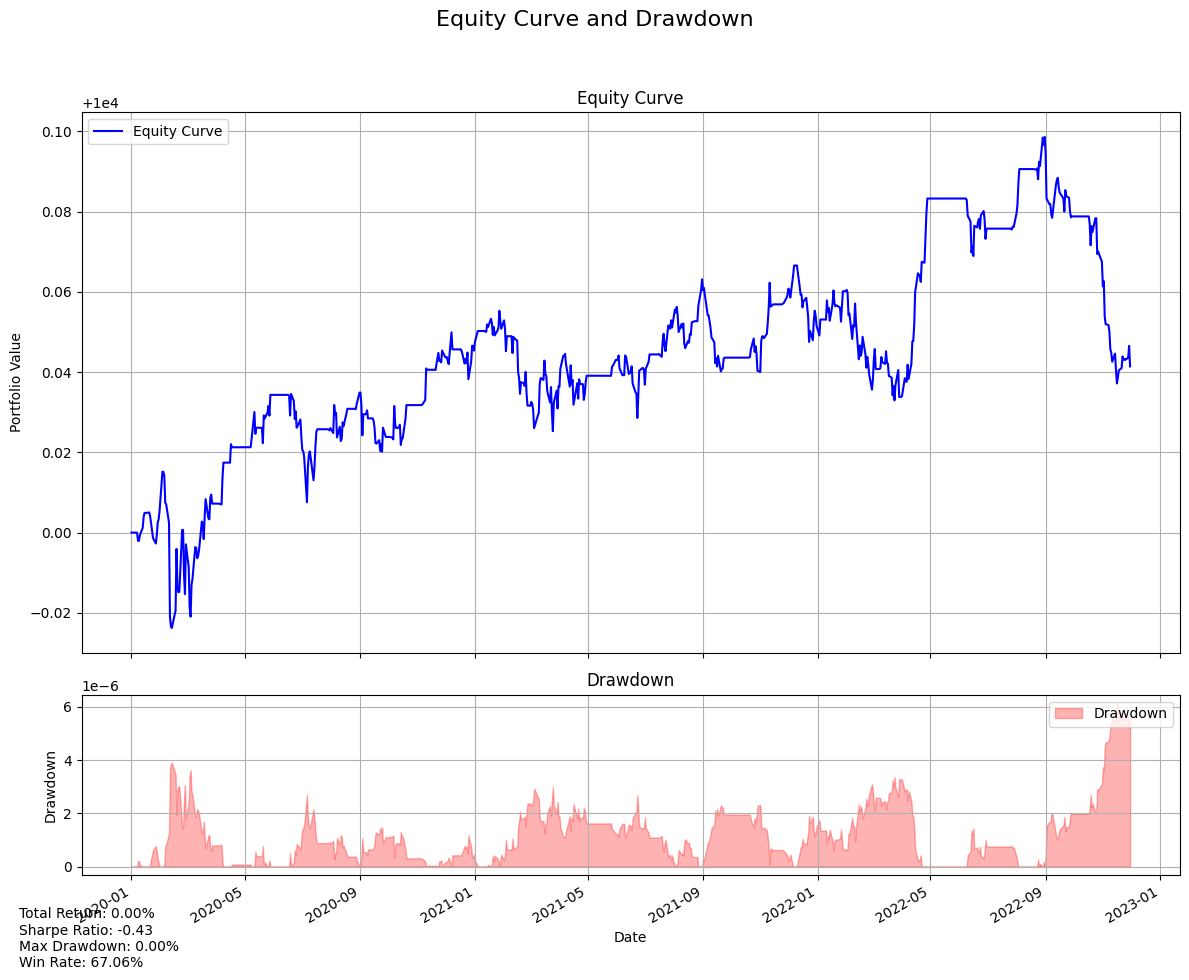

<IPython.core.display.Javascript object>

C:\Users\Reinier\AppData\Local\Temp\ipykernel_10764\3645758699.py:161: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 2)
C:\Users\Reinier\AppData\Local\Temp\ipykernel_10764\3645758699.py:169: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


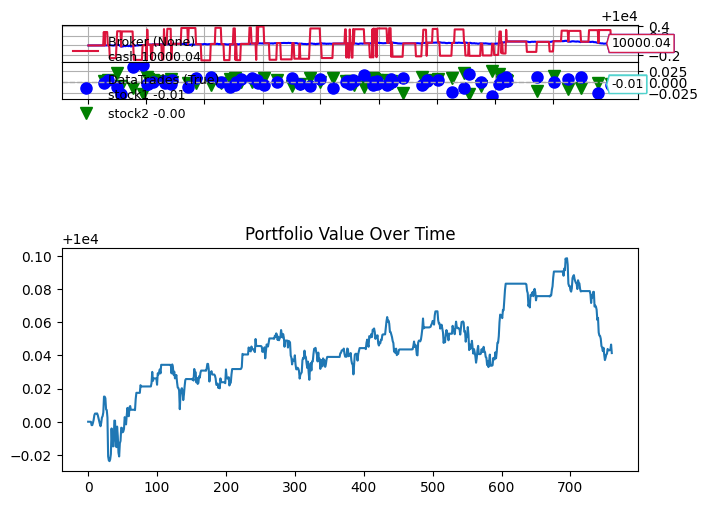

In [23]:
import pandas as pd
import numpy as np
%matplotlib inline

def main():
    # Define all parameters
    params = {
        # Data parameters
        'stock1': "AUDCAD=X",
        'stock2': "AUDEUR=X",
        'start_date': '2020-01-01',
        'end_date': '2023-01-01',
        
        # Strategy parameters
        'lookback': 20,
        'entry_threshold': 1.5,
        'stoploss_factor': 2.0,
        'kappa': 0.06,
        'half_life': 12.25,
        
        # Backtest parameters
        'initial_capital': 100000,
        'commission': 0.001,  # 0.1% commission
    }
    
    # Load data
    df1 = pd.read_csv(f'data/{params["stock1"]}.csv', index_col='Date', parse_dates=True)
    df2 = pd.read_csv(f'data/{params["stock2"]}.csv', index_col='Date', parse_dates=True)
    
    # Ensure both stocks have the same date range
    common_dates = df1.index.intersection(df2.index)
    df1 = df1.loc[common_dates]
    df2 = df2.loc[common_dates]
    
    # Calculate Kappa and Half-Life if not provided
    if params['kappa'] is None or params['half_life'] is None:
        params['kappa'], params['half_life'] = calculate_kappa_and_half_life(df1, df2)
        print(f"Calculated Kappa: {params['kappa']:.2f}")
        print(f"Calculated Half-Life: {params['half_life']:.2f}")
    
    # Create BacktestEngine instance
    engine = BacktestEngine(
        strategy_class=PairTradingStrategy,
        df1=df1,
        df2=df2,
        initial_capital=params['initial_capital']
    )

    # Set strategy parameters
    engine.set_strategy(
        lookback=params['lookback'],
        entry_threshold=params['entry_threshold'],
        stoploss_factor=params['stoploss_factor'],
        # kappa=params['kappa'],
        half_life=params['half_life'],
        stock1="stock1",
        stock2="stock2"
    )

    # Set broker parameters
    engine.set_broker(commission=params['commission'], initial_capital=params['initial_capital'])

    # Run the backtest
    engine.run()

    # # print trade table
    # engine.print_trade_table()

    # Get and print metrics
    engine.print_metrics()

    # Plot the equity curve
    engine.plot_equity_curve()

    # Plot the results
    engine.plot_results()

if __name__ == "__main__":
    main()

# 4. Bayesian optimization to find best parameters

### Define Bayesian Optimization Function

In [24]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

def objective(params, df1, df2, initial_capital=100000, commission=0.001):
    lookback, entry_threshold, stoploss_factor, holding_time_factor, half_life = params
    
    engine = BacktestEngine(
        strategy_class=PairTradingStrategy,
        df1=df1,
        df2=df2,
        initial_capital=initial_capital
    )
    
    engine.set_strategy(
        lookback=int(lookback),
        entry_threshold=entry_threshold,
        stoploss_factor=stoploss_factor,
        holding_time_factor=holding_time_factor,
        half_life=half_life,
        stock1="stock1",
        stock2="stock2"
    )
    
    engine.set_broker(commission=commission, initial_capital=initial_capital)
    engine.run()
    metrics = engine.get_metrics()
    
    # We want to maximize Sharpe Ratio, so we return its negative
    return -metrics.get('Sharpe Ratio', 0)

def bayesian_optimization(df1, df2, param_ranges, n_calls=50, initial_capital=100000, commission=0.001):
    space = [
        Integer(param_ranges['lookback'][0].min(), param_ranges['lookback'][0].max(), name='lookback'),
        Real(param_ranges['entry_threshold'][0].min(), param_ranges['entry_threshold'][0].max(), name='entry_threshold'),
        Real(param_ranges['stoploss_factor'][0].min(), param_ranges['stoploss_factor'][0].max(), name='stoploss_factor'),
        Real(param_ranges['holding_time_factor'][0].min(), param_ranges['holding_time_factor'][0].max(), name='holding_time_factor'),
    ]
    
    fixed_half_life = param_ranges['half_life'][0]
    
    @use_named_args(space)
    def objective_wrapper(**params):
        params_list = list(params.values()) + [fixed_half_life]
        return objective(params_list, df1, df2, initial_capital, commission)
    
    def callback(res):
        n = len(res.x_iters)
        print(f"Optimization progress: {n / n_calls * 100:.2f}%")
    
    result = gp_minimize(objective_wrapper, space, n_calls=n_calls, random_state=42, callback=callback)
    
    best_params = {
        'lookback': int(result.x[0]),
        'entry_threshold': result.x[1],
        'stoploss_factor': result.x[2],
        'holding_time_factor': result.x[3],
        'half_life': fixed_half_life
    }
    
    return best_params, -result.fun  # Return best parameters and best Sharpe Ratio

### Run to find best parameters

**************************************************
Finding the best pair for pair trading...
Completed pair analysis.
**************************************************
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
**************************************************
Stock Pair for Pair Trading:
Stock 1: GBPJPY=X
Stock 2: NZDJPY=X
Kappa: 0.02
Half-Life: 27.88
**************************************************
Optimization progress: 2.00%
Optimization progress: 4.00%
Optimization progress: 6.00%
Optimization progress: 8.00%
Optimization progress: 10.00%
Optimization progress: 12.00%
Optimization progress: 14.00%
Optimization progress: 16.00%
Optimization progress: 18.00%
Optimization progress: 20.00%
Optimization progress: 22.00%
Optimization progress: 24.00%
Optimization progress: 26.00%
Optimization progress: 28.00%
Optimization progress: 30.00%
Optimization progress: 32.00%
Optimization progress

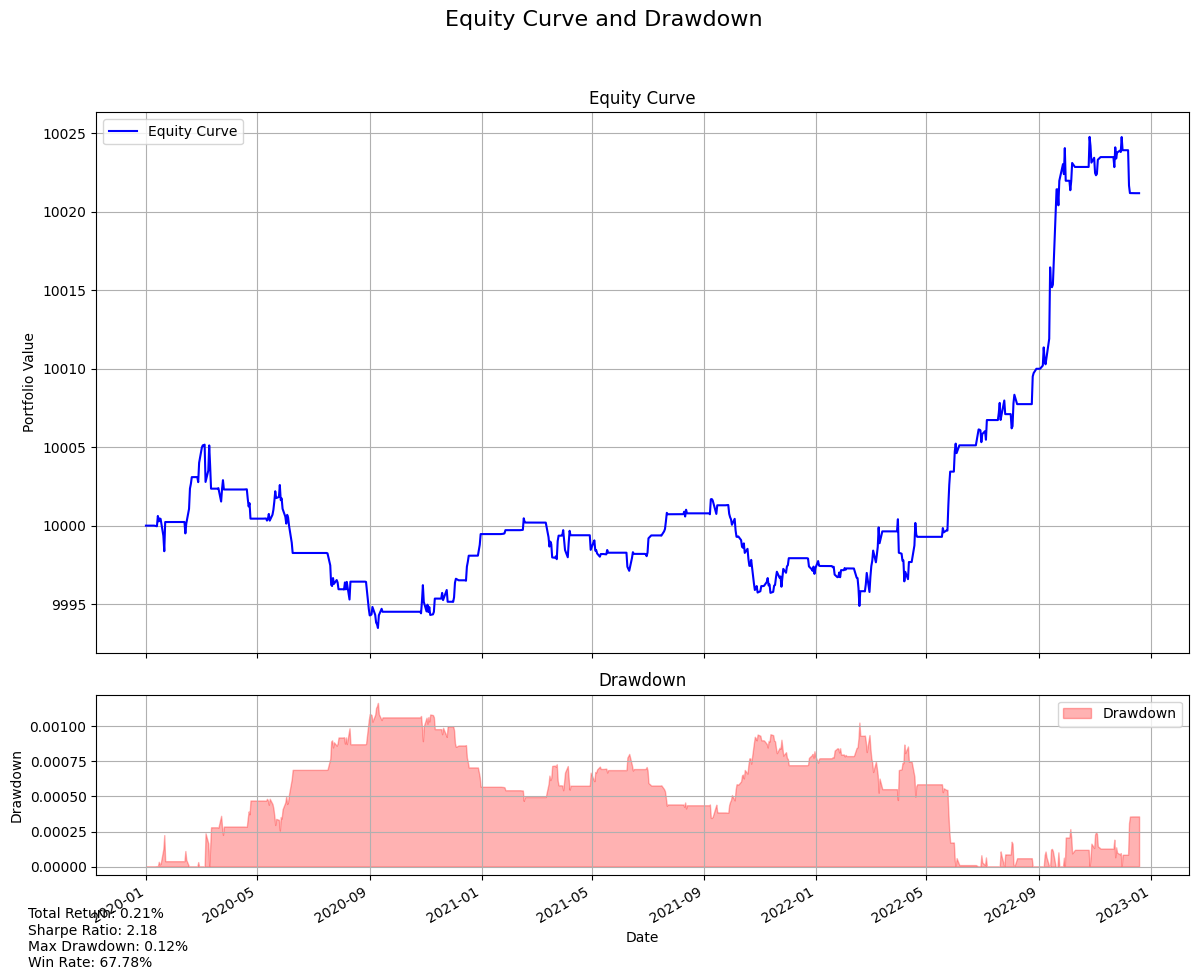

In [25]:
import yfinance as yf
import numpy as np
%matplotlib inline

def main():
    # Find the best pair for pair trading
    print("*" * 50)
    print("Finding the best pair for pair trading...")
    best_pair, suitable_pairs = find_best_pair(list_tickers)
    print("Completed pair analysis.")
    print("*" * 50)
    if best_pair is None:
        print("No suitable pairs found for pair trading.")
        return
    
    # get the best pair
    stock1 = best_pair['stock1']
    stock2 = best_pair['stock2']

    # Download stock data
    start_date = "2020-01-01"
    end_date = "2023-01-01"
    
    df1 = yf.download(stock1, start=start_date, end=end_date)
    df2 = yf.download(stock2, start=start_date, end=end_date)

    # Calculate kappa and half life
    kappa, half_life = calculate_kappa_and_half_life(df1, df2, plot=False)
    
    # Print CONFIG before optimization
    print("*" * 50)
    print("Stock Pair for Pair Trading:")
    print(f'Stock 1: {stock1}')
    print(f'Stock 2: {stock2}')
    print(f'Kappa: {kappa:.2f}')
    print(f'Half-Life: {half_life:.2f}')
    print("*" * 50)
    
    # Define parameter ranges for Bayesian optimization
    look_back_range = np.arange(5, 31, 1)
    entry_threshold_range = np.arange(1.5, 3.1, 0.1)
    stoploss_factor_range = np.arange(1.5, 3.1, 0.1)
    holding_time_factor_range = np.arange(1.0, 2.1, 0.1)
    param_ranges = {
        'lookback': [look_back_range],
        'entry_threshold': [entry_threshold_range],
        'stoploss_factor': [stoploss_factor_range],
        'holding_time_factor': [holding_time_factor_range],
        'half_life': [half_life]
    }
    
    # Run Bayesian optimization
    best_params, best_sharpe = bayesian_optimization(df1, df2, param_ranges, n_calls=50)
    
    print("*" * 50)
    print("\nBest parameters found:")
    for key, value in best_params.items():
        print(f"{key}: {value}")
    print(f"Best Sharpe Ratio: {best_sharpe}")
    print("*" * 50)
    
    # Run final backtest with best parameters
    final_engine = BacktestEngine(
        strategy_class=PairTradingStrategy,
        df1=df1,
        df2=df2,
        initial_capital=100000
    )
    
    final_engine.set_strategy(**best_params, stock1="stock1", stock2="stock2")
    
    final_engine.set_broker(commission=0.001, initial_capital=100000)
    final_engine.run()
    
    print("*" * 50)
    print("\nFinal Backtest Results:")
    final_engine.print_metrics()
    final_engine.plot_equity_curve()

if __name__ == "__main__":
    main()